## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [62]:
df = pd.read_csv('540-ws-training.xml.csv')

In [63]:
df

,patient,id,weight,insulin_type,cgm_ts,cgm_value,fingerstick_ts,fingerstick_value,basalevent_ts,value,...,basis_sleep,event.4,tbegin,tend,quality,type.2,acceleration,event.5,ts.2,value.4
0,NaN,540.0,99.0,Humalog,19-05-2027 11:36:29,76.0,19-05-2027 07:18:33,144.0,19-05-2027 00:00:00,0.80,...,NaN,NaN,23-05-2027 20:04:00,23-05-2027 20:55:00,0.0,,NaN,NaN,19-05-2027 09:55:00,0.978923
1,NaN,NaN,NaN,NaN,19-05-2027 11:41:29,72.0,19-05-2027 11:22:37,80.0,19-05-2027 05:00:00,1.05,...,NaN,NaN,04-06-2027 15:22:00,04-06-2027 15:56:00,0.0,,NaN,NaN,19-05-2027 09:56:00,1.007560
2,NaN,NaN,NaN,NaN,19-05-2027 11:46:29,68.0,19-05-2027 11:36:29,80.0,19-05-2027 09:00:00,0.95,...,NaN,NaN,05-06-2027 21:15:00,06-06-2027 04:25:00,0.0,,NaN,NaN,19-05-2027 09:57:00,1.031561
3,NaN,NaN,NaN,NaN,19-05-2027 11:51:29,65.0,19-05-2027 16:22:43,71.0,19-05-2027 14:00:00,0.40,...,NaN,NaN,07-06-2027 15:15:00,07-06-2027 16:31:00,0.0,,NaN,NaN,19-05-2027 09:58:00,1.048852
4,NaN,NaN,NaN,NaN,19-05-2027 11:56:29,63.0,19-05-2027 16:36:31,71.0,22-05-2027 00:00:00,0.80,...,NaN,NaN,08-06-2027 21:01:00,09-06-2027 04:21:00,0.0,,NaN,NaN,19-05-2027 09:59:00,0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-07-2027 21:12:00,1.010733
28349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-07-2027 21:13:00,1.045706
28350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-07-2027 21:14:00,1.050903
28351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-07-2027 21:15:00,1.122516


## Data Preprocessing

### Converting to Datetime Format

In [4]:
selected_columns = ['cgm_ts', 'cgm_value']
cgmdf = df[selected_columns]
cgmdf['cgm_ts'] = pd.to_datetime(df['cgm_ts'], format='%d-%m-%Y %H:%M:%S')
cgmdf = cgmdf.rename(columns={'cgm_ts':'ts', 'cgm_value':'value'})

In [5]:
selected_columns = ['fingerstick_ts', 'fingerstick_value']
fsdf = df[selected_columns]
fsdf['fingerstick_ts'] = pd.to_datetime(df['fingerstick_ts'], format='%d-%m-%Y %H:%M:%S')
fsdf = fsdf.rename(columns={'fingerstick_ts':'ts', 'fingerstick_value':'value'})

### Combining all blood glucose readings

In [6]:
#Combine CGM and fingerstick readings
gldf = pd.concat([cgmdf, fsdf], ignore_index=True)

#Sort by time
gldf.sort_values(by='ts', inplace = True)

#Remove 0 values from data.
gldf = gldf[gldf['value'] != 0]

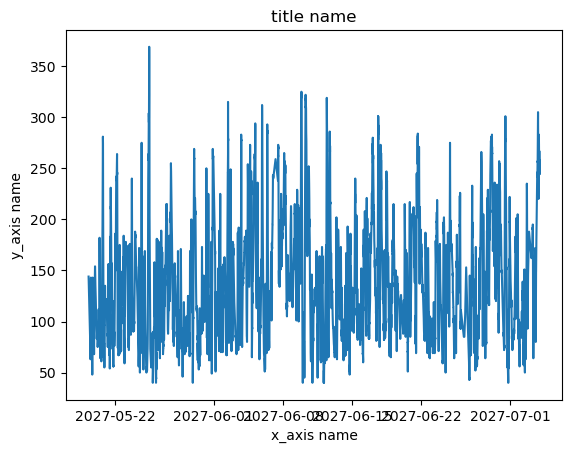

In [7]:
plt.plot(gldf['ts'], gldf['value'])
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

In [8]:
#Creating 5min averaged bins for the glucose information.
gldf = gldf.groupby(pd.Grouper(key='ts', freq='5min')).mean().dropna()

In [9]:
gldf

,value
ts,
2027-05-19 07:15:00,144.0
2027-05-19 11:20:00,80.0
2027-05-19 11:35:00,78.0
2027-05-19 11:40:00,72.0
2027-05-19 11:45:00,68.0
...,...
2027-07-03 23:35:00,255.0
2027-07-03 23:40:00,258.0
2027-07-03 23:45:00,258.0


## Modelling

### Bergman Test Model

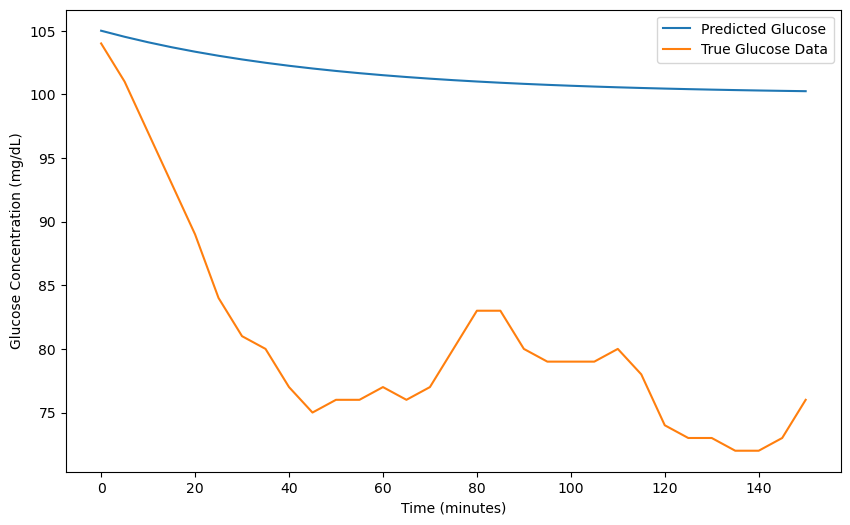

Mean Absolute Error (MAE): 21.070153139285573
Mean Squared Error (MSE): 491.94288324538053
Root Mean Squared Error (RMSE): 22.179785464367786
R-squared (R^2): -6.565808513888083


In [87]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 09:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Time points for simulation
t_points = np.linspace(0, 150, 31)

# Bergman model equations
def bergman_model(y, t, P, S_i):
    G, X = y
    dGdt = -S_i * G + P
    dXdt = G - X
    return [dGdt, dXdt]

G0 = 105.0  # Initial glucose concentration (mg/dL)
X0 = 5   # Initial insulin action (unknown)

# Parameters
P = 2.0     # Glucose input rate (mg/dL/min)
S_i = 0.02  # Insulin sensitivity (mg/dL per min per microU/mL)

y0 = [G0, X0]
solution = odeint(bergman_model, y0, t, args=(P, S_i))

glucose_data = solution[:, 0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, glucose_data)
print("R-squared (R^2):", r_squared)


### Hovorka - Bayesian Parameter Estimation

#### Test Case 1

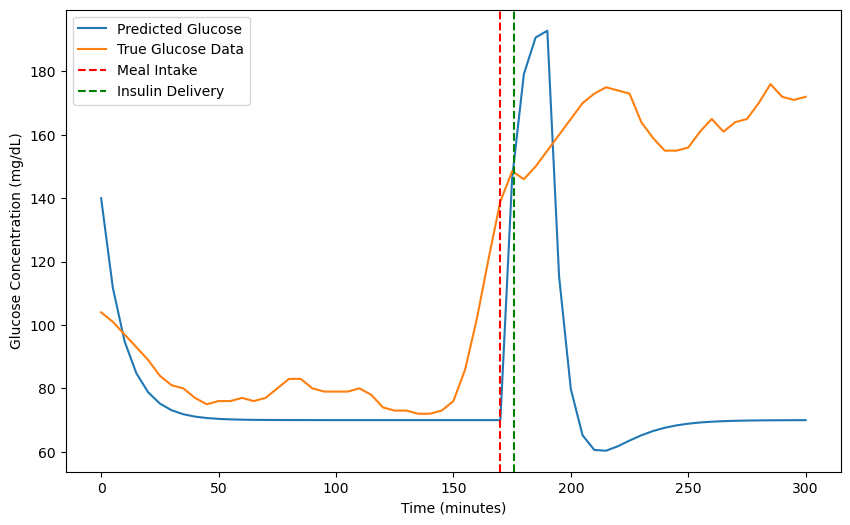

Mean Absolute Error (MAE): 43.35127786449707
Mean Squared Error (MSE): 3666.512451816551
Root Mean Squared Error (RMSE): 60.55173368134517
R-squared (R^2): -1.1637379827097822


In [191]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 12:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16
k_1_true = 0.05
k_2_true = 0.05
k_3_true = 0.05
k_4_true = 0.05
k_e_true = 0.1   

t_points = np.linspace(0, 300, 61)
G_init = 140  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=current_params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

    
# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
  
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.axvline(x=meal_time, color='r', linestyle='--', label='Meal Intake')
plt.axvline(x=delivery_time, color='g', linestyle='--', label='Insulin Delivery')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, glucose_data)
print("R-squared (R^2):", r_squared)

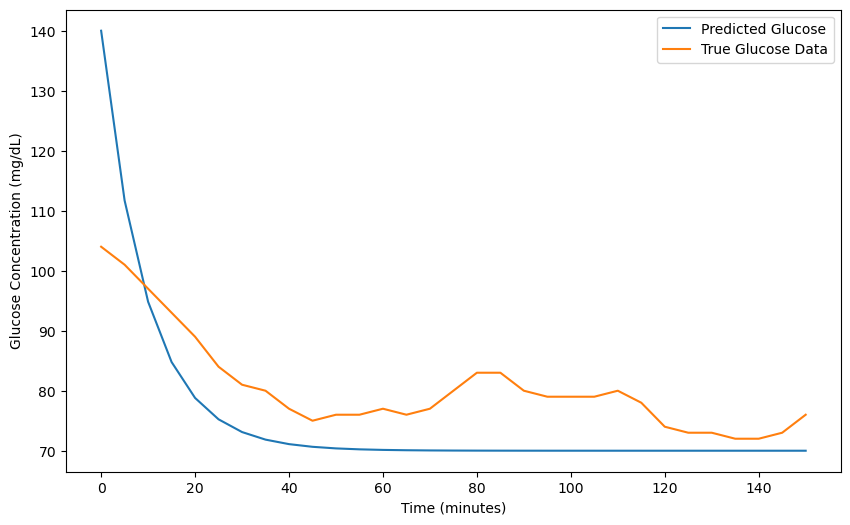

Mean Absolute Error (MAE): 7.980339235234423
Mean Squared Error (MSE): 99.09011928257954
Root Mean Squared Error (RMSE): 9.95440200527282
R-squared (R^2): -0.5239510391217066


In [88]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 09:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16  
k_1_true = 0.05  
k_2_true = 0.05 
k_3_true = 0.05 
k_4_true = 0.05 
k_e_true = 0.1  

t_points = np.linspace(0, 150, 31)
G_init = 140  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()  # Starting with the true parameters

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, glucose_data)
print("R-squared (R^2):", r_squared)

#### Test Case 2

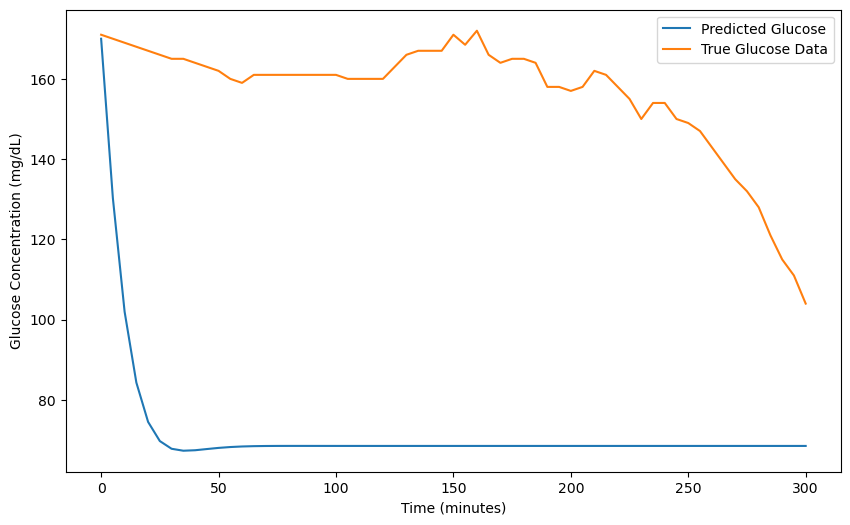

Mean Absolute Error (MAE): 84.36687667582261
Mean Squared Error (MSE): 7480.096182789248
Root Mean Squared Error (RMSE): 86.48754929346332
R-squared (R^2): -33.39360540363787


In [124]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 07:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16
k_1_true = 0.05
k_2_true = 0.05
k_3_true = 0.05
k_4_true = 0.05
k_e_true = 0.1   

t_points = np.linspace(0, 300, 61)
G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=current_params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()  # Starting with the true parameters

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

    
# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
  
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')

plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, glucose_data)
print("R-squared (R^2):", r_squared)

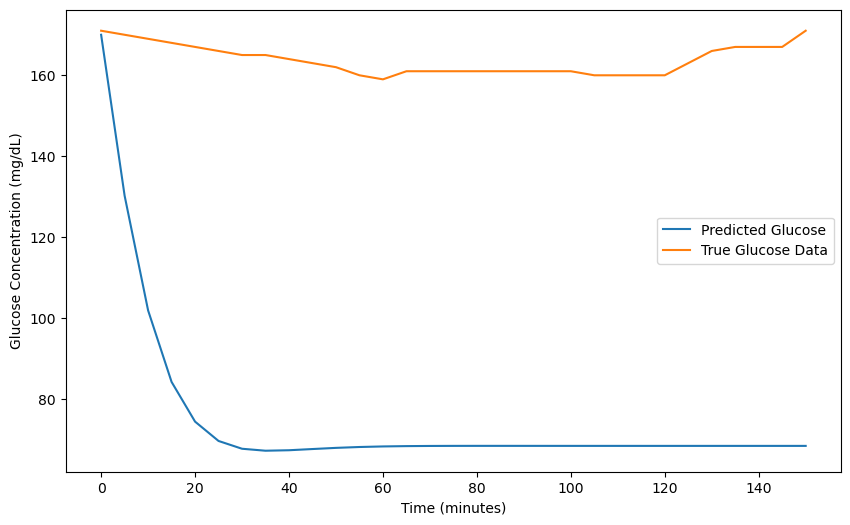

Mean Absolute Error (MAE): 88.34494921936407
Mean Squared Error (MSE): 8181.654447962093
Root Mean Squared Error (RMSE): 90.45249829585744
R-squared (R^2): -628.6100195781207


In [126]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 04:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16  
k_1_true = 0.05  
k_2_true = 0.05 
k_3_true = 0.05 
k_4_true = 0.05 
k_e_true = 0.1  

t_points = np.linspace(0, 150, 31)
G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()  # Starting with the true parameters

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, glucose_data)
print("R-squared (R^2):", r_squared)

#### Test Case 3

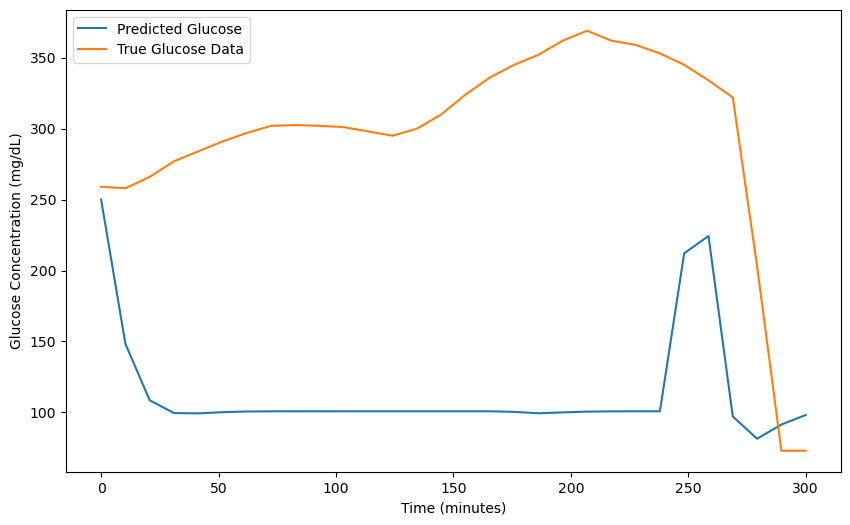

Mean Absolute Error (MAE): 184.00576315643522
Mean Squared Error (MSE): 38779.44270963999
Root Mean Squared Error (RMSE): 196.92496720741124
R-squared (R^2): -6.947335889846453


In [132]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 14:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16
k_1_true = 0.05
k_2_true = 0.05
k_3_true = 0.05
k_4_true = 0.05
k_e_true = 0.1   

t_points = np.linspace(0, 300, 30)
G_init = 250  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=current_params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()  # Starting with the true parameters

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

    
# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
  
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')

plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, glucose_data)
print("R-squared (R^2):", r_squared)

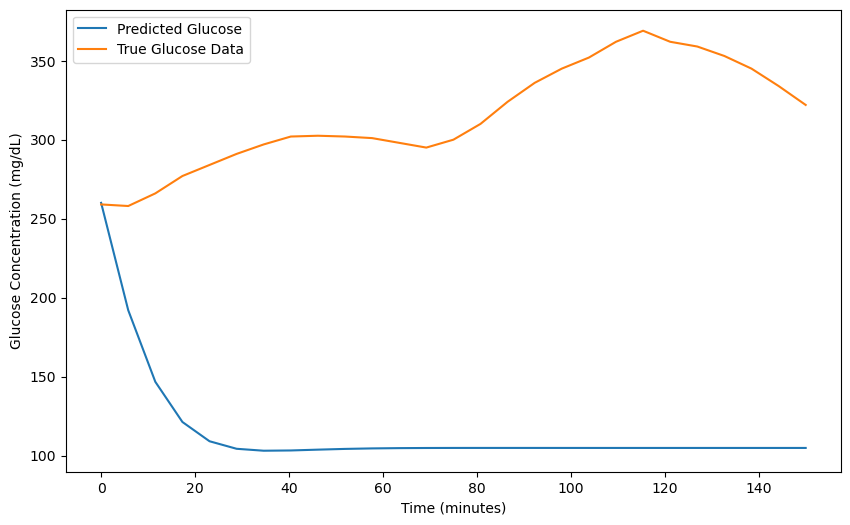

Mean Absolute Error (MAE): 199.21380987849565
Mean Squared Error (MSE): 43053.93611149941
Root Mean Squared Error (RMSE): 207.49442429014667
R-squared (R^2): -39.7375667712803


In [131]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 11:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G_true = 0.16  
k_1_true = 0.05  
k_2_true = 0.05 
k_3_true = 0.05 
k_4_true = 0.05 
k_e_true = 0.1  

t_points = np.linspace(0, 150, 27)
G_init = 260  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

# Simulated glucose data
glucose_data = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]

# Bayesian parameter estimation with Metropolis-Hastings
# Define the likelihood function
def likelihood(params, glucose_data):
    simulated_data = sim(params=params ,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:,0]
    likelihood = np.exp(-0.5 * np.sum((glucose_data - simulated_data) ** 2))
    return likelihood

# Define the prior distribution
def prior(params):
    return 1.0

# Define the posterior distribution (proportional to likelihood * prior)
def posterior(params, glucose_data):
    return likelihood(params, glucose_data) * prior(params)

# Metropolis-Hastings sampling
num_samples = 10000
samples = []
current_params = true_params.copy()  # Starting with the true parameters

for _ in range(num_samples):
    proposed_params = {param: current_params[param] + np.random.normal(0, 0.01) for param in true_params}
    acceptance_ratio = posterior(proposed_params, glucose_data) / posterior(current_params, glucose_data)
    if np.random.rand() < acceptance_ratio:
        current_params = proposed_params
    samples.append(current_params)

# Simulated glucose data
glucose_data1 = sim(params=current_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, glucose_data, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, glucose_data)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, glucose_data)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, glucose_data)
print("R-squared (R^2):", r_squared)

### Hovorka - Linear Regression Parameter Estimation

#### Test Case 1

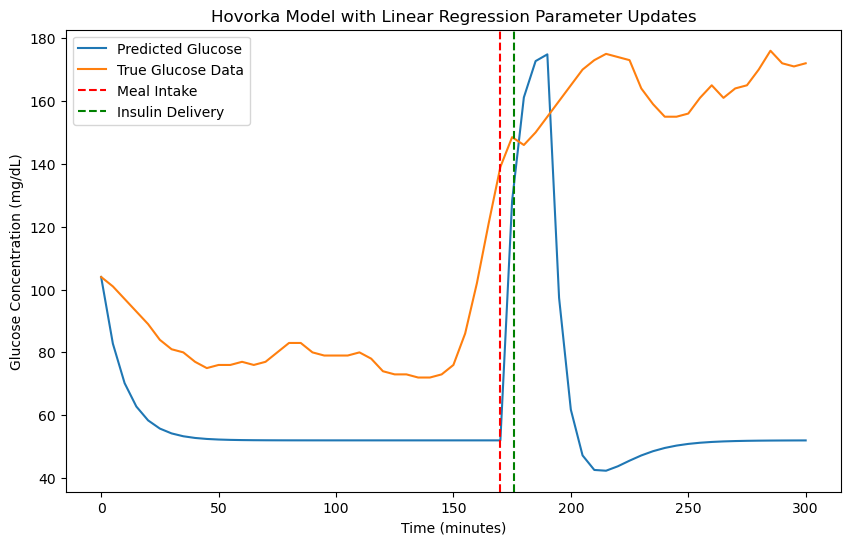

Mean Absolute Error (MAE): 58.7996208295847
Mean Squared Error (MSE): 5377.867872546521
Root Mean Squared Error (RMSE): 73.33394761327472
R-squared (R^2): -2.1736690205588762


In [14]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 12:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

G_init = 104  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 61)

# Simulate Hovorka model with meal intake and insulin delivery using odeint
def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.axvline(x=meal_time, color='r', linestyle='--', label='Meal Intake')
plt.axvline(x=delivery_time, color='g', linestyle='--', label='Insulin Delivery')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


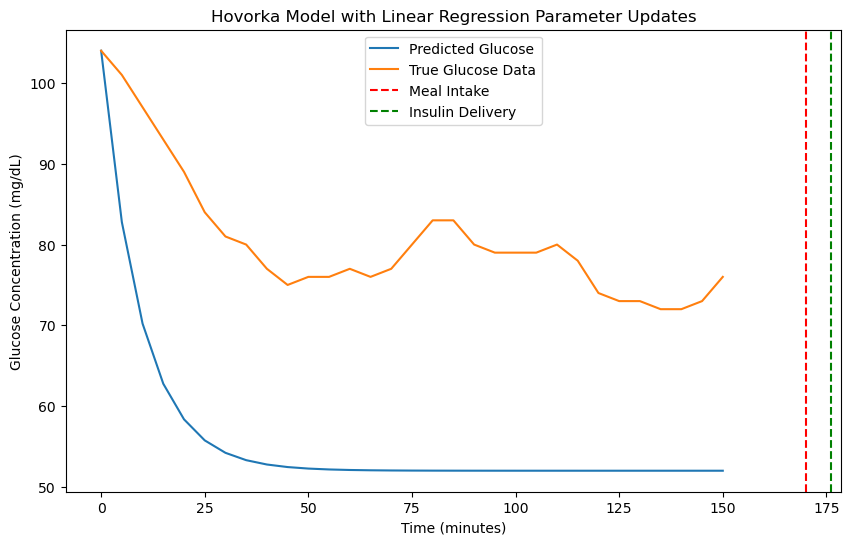

Mean Absolute Error (MAE): 24.443207614758418
Mean Squared Error (MSE): 628.7824338560034
Root Mean Squared Error (RMSE): 25.075534567701713
R-squared (R^2): -8.670324855737597


In [15]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 09:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

# Initial conditions
G_init = 104  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

# Time points for simulation
t_points = np.linspace(0, 150, 31)

# Simulate Hovorka model with meal intake and insulin delivery using odeint
def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values2 - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.axvline(x=meal_time, color='r', linestyle='--', label='Meal Intake')
plt.axvline(x=delivery_time, color='g', linestyle='--', label='Insulin Delivery')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, predicted_glucose)
print("R-squared (R^2):", r_squared)


#### Test Case 2

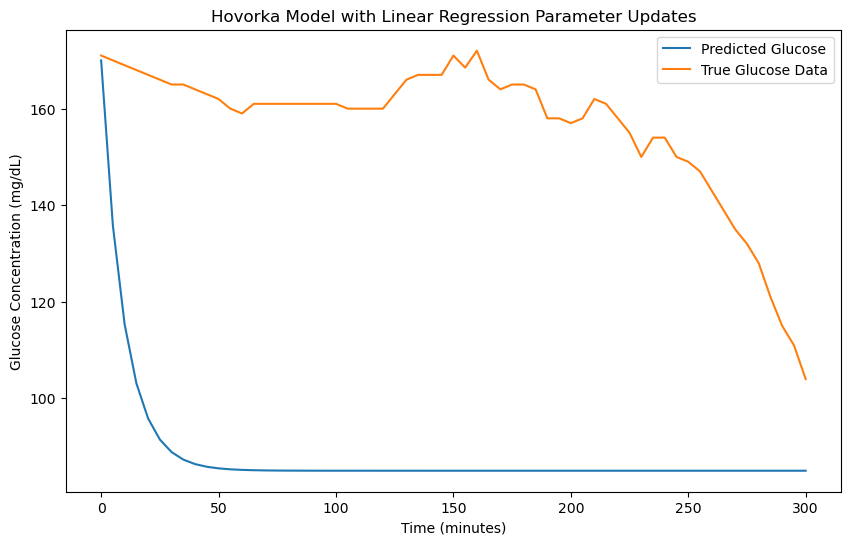

Mean Absolute Error (MAE): 67.95688727931527
Mean Squared Error (MSE): 4916.982537078072
Root Mean Squared Error (RMSE): 70.12119891358157
R-squared (R^2): -21.608366660571612


In [137]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 07:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 61)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


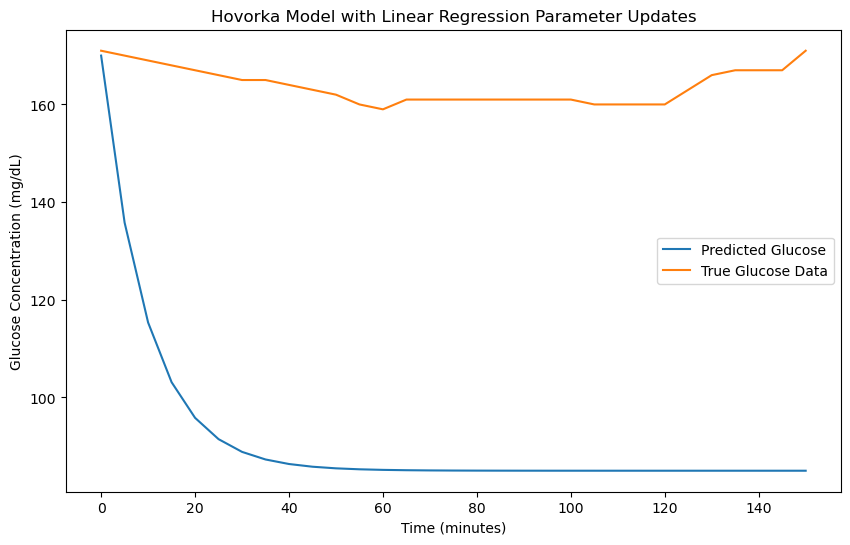

Mean Absolute Error (MAE): 71.99581111096776
Mean Squared Error (MSE): 5434.312521457243
Root Mean Squared Error (RMSE): 73.71778972173028
R-squared (R^2): -417.19141040362035


In [135]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 04:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

# Initial conditions
G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

# Time points for simulation
t_points = np.linspace(0, 150, 31)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values2 - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, predicted_glucose)
print("R-squared (R^2):", r_squared)


#### Test Case 3

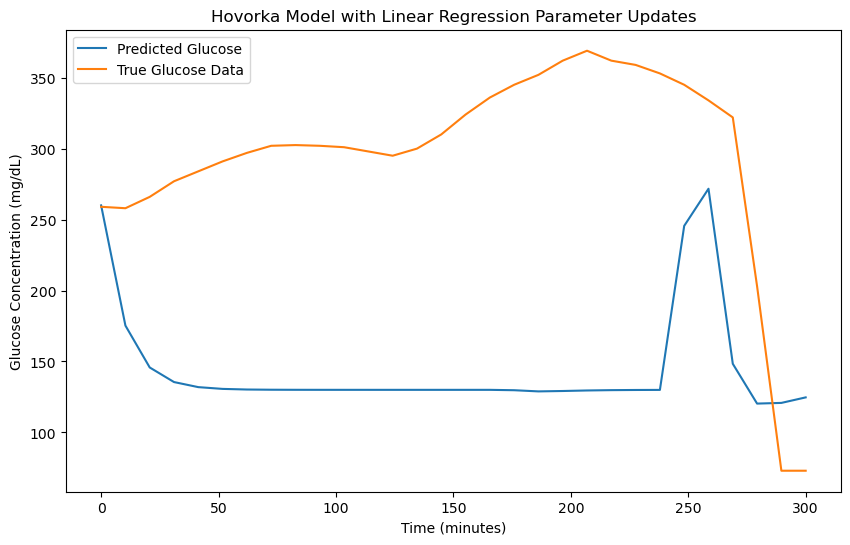

Mean Absolute Error (MAE): 156.91671791089848
Mean Squared Error (MSE): 28414.216423150876
Root Mean Squared Error (RMSE): 168.56516966191703
R-squared (R^2): -4.823119317427341


In [140]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 14:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

G_init = 260  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 30)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


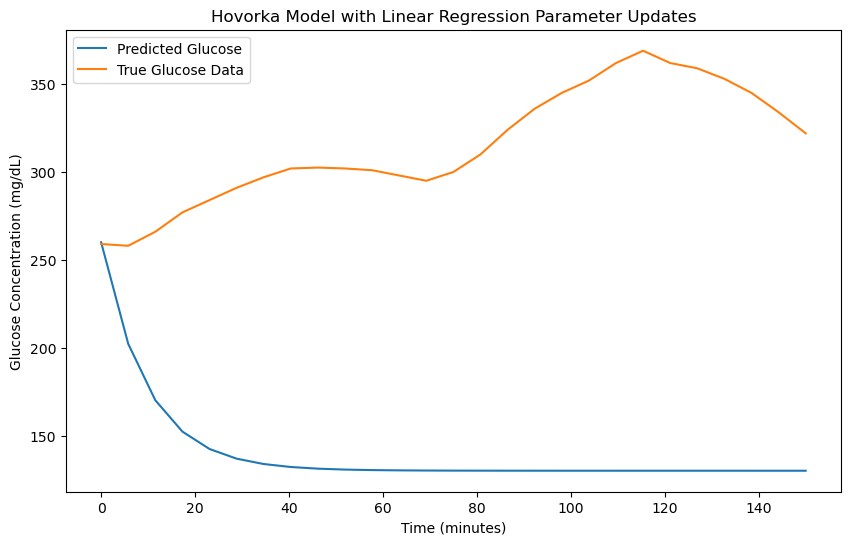

Mean Absolute Error (MAE): 174.26541527428887
Mean Squared Error (MSE): 33290.24598532561
Root Mean Squared Error (RMSE): 182.45614811599418
R-squared (R^2): -30.499178498974125


In [143]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 11:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values2 = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.05
k_2 = 0.05
k_3 = 0.05
k_4 = 0.05
k_e = 0.1   

# Initial conditions
G_init = 260  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

# Time points for simulation
t_points = np.linspace(0, 150, 27)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

# Linear regression parameter updates
num_iterations = 1000
learning_rate = 0.01
updated_params = {'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e}

for iteration in range(num_iterations):
    predicted_glucose = sim(params={'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4, 'k_e': k_e},meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]
    gradient = true_values2 - predicted_glucose / len(t_points)
    for param in updated_params:
        updated_params[param] += learning_rate * gradient

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values2, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.title('Hovorka Model with Linear Regression Parameter Updates')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values2, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values2, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values2, predicted_glucose)
print("R-squared (R^2):", r_squared)


### Hovorka - Random Forest Parameter Estimation

#### Test Case 1

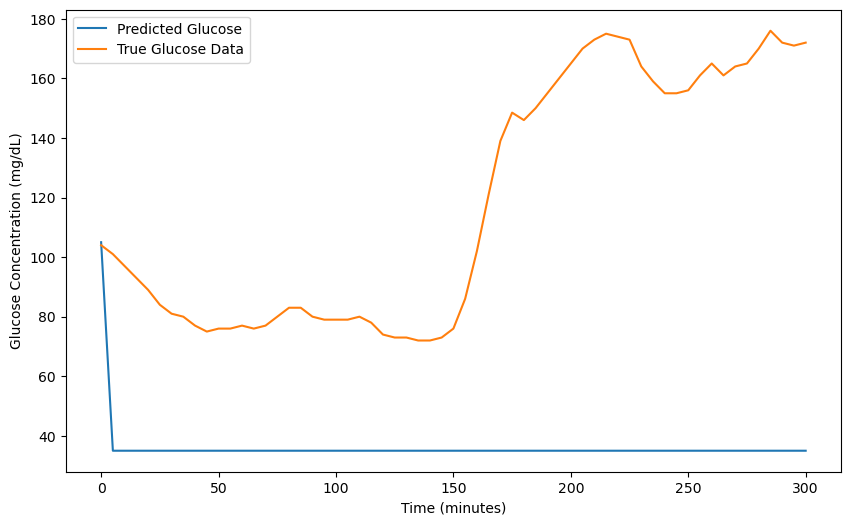

Mean Absolute Error (MAE): 81.92622950819714
Mean Squared Error (MSE): 8512.299180327922
Root Mean Squared Error (RMSE): 92.26212213215086
R-squared (R^2): -4.023407201996436


In [192]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 12:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters from bayesian estimation
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726  

G_init = 105  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 61)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)


# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters


estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


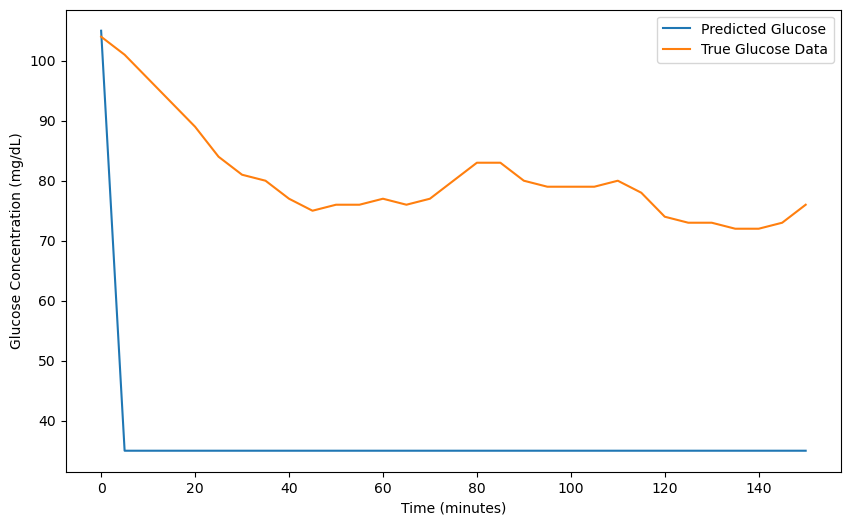

Mean Absolute Error (MAE): 43.35483870967823
Mean Squared Error (MSE): 1986.1290322581701
Root Mean Squared Error (RMSE): 44.5660075871529
R-squared (R^2): -29.54556220593576


In [193]:
start_time = pd.to_datetime('2027-05-23 07:00:00')
end_time = pd.to_datetime('2027-05-23 09:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726   

G_init = 105  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 150, 31)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 170  # Time of meal intake (min)
meal_amount = 70  # Amount of consumed carbohydrates (g)
insulin_delivery = 7.7  # Insulin delivery rate (mU/L/min)
delivery_time = 176  # Time of insulin delivery (min)


# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters

estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


#### Test Case 2

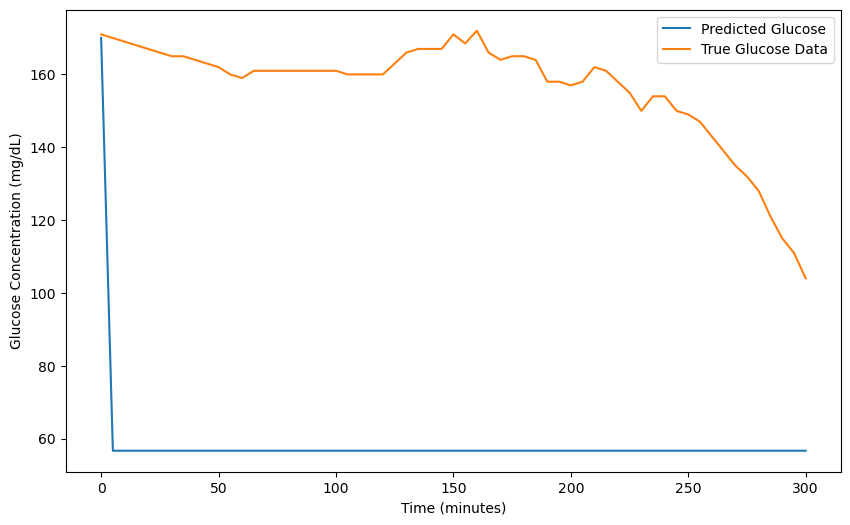

Mean Absolute Error (MAE): 97.89344262295155
Mean Squared Error (MSE): 9953.539617486515
Root Mean Squared Error (RMSE): 99.76742763791454
R-squared (R^2): -44.76653904009742


In [194]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 07:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726    

G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 61)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)


# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters

# Estimate Hovorka model parameters from noisy glucose data
estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


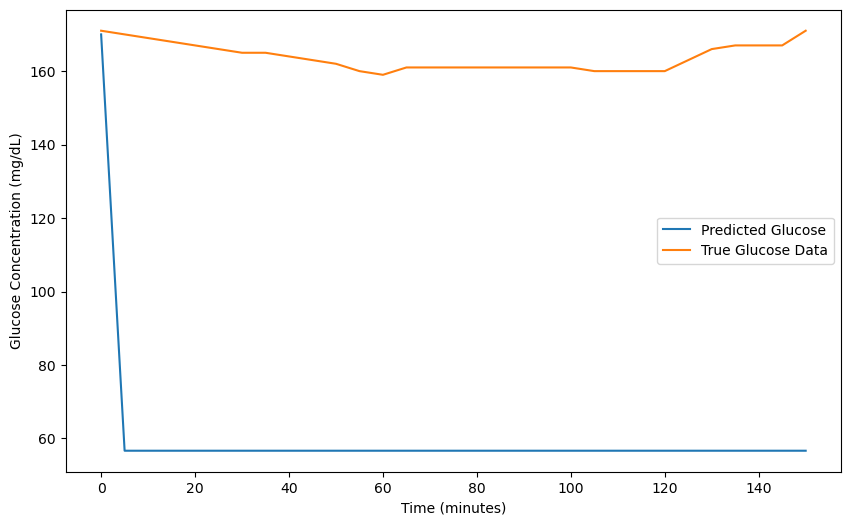

Mean Absolute Error (MAE): 103.48387096774348
Mean Squared Error (MSE): 11070.279569892813
Root Mean Squared Error (RMSE): 105.21539606869716
R-squared (R^2): -850.9009182148458


In [195]:
start_time = pd.to_datetime('2027-05-23 02:00:00')
end_time = pd.to_datetime('2027-05-23 04:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726    

G_init = 170  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 150, 31)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 0  # Time of meal intake (min)
meal_amount = 0  # Amount of consumed carbohydrates (g)
insulin_delivery = 0  # Insulin delivery rate (mU/L/min)
delivery_time = 0  # Time of insulin delivery (min)


# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters

# Estimate Hovorka model parameters from noisy glucose data
estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


#### Test Case 3

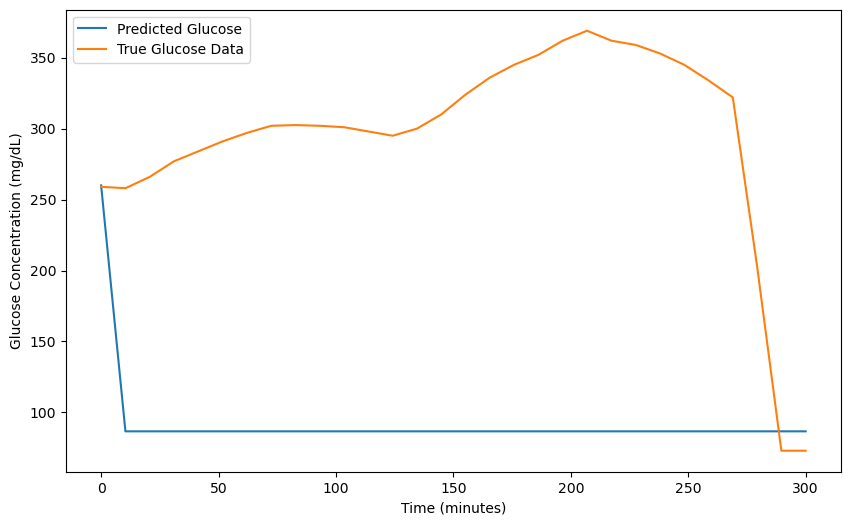

Mean Absolute Error (MAE): 204.59444444444478
Mean Squared Error (MSE): 47354.926851851975
Root Mean Squared Error (RMSE): 217.61187203792898
R-squared (R^2): -8.704768388464306


In [196]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 14:00:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726   

G_init = 260  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 30)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters

# Estimate Hovorka model parameters from noisy glucose data
estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)


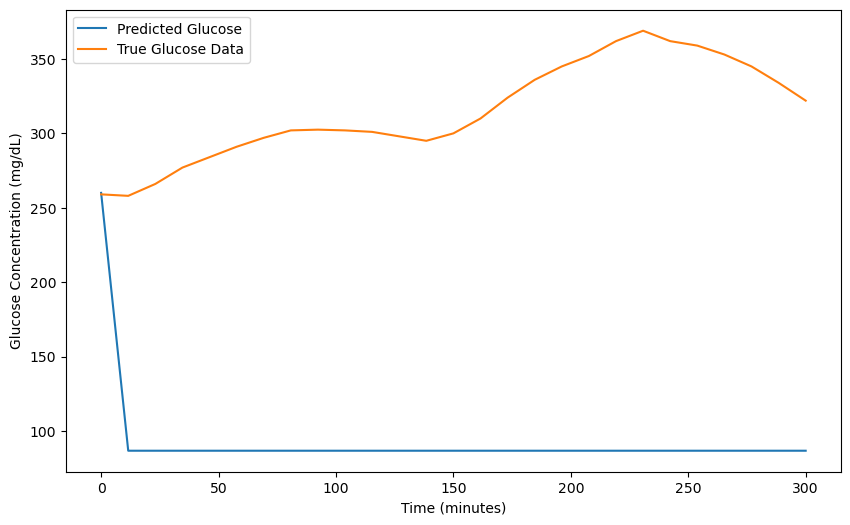

Mean Absolute Error (MAE): 222.00617283950632
Mean Squared Error (MSE): 52101.51131687248
Root Mean Squared Error (RMSE): 228.25755478597523
R-squared (R^2): -48.29836822953818


In [197]:
start_time = pd.to_datetime('2027-05-25 09:00:00')
end_time = pd.to_datetime('2027-05-25 11:30:00')

filtdf = gldf[(gldf.index >= start_time) & (gldf.index <= end_time)]

true_values = filtdf['value']

# Hovorka model parameters
V_G = 0.16
k_1 = 0.03989
k_2 = 0.04809
k_3 = 0.04452
k_4 = 0.05192
k_e = 0.10726  

G_init = 260  # Initial glucose concentration (mg/dL)
I_init = 5    # Initial insulin concentration (mU/L)

t_points = np.linspace(0, 300, 27)

def hovorka_model(y, t, params, meal_time, meal_amount, insulin_delivery, delivery_time):
    G, I = y
    dG_dt = -params['k_1'] * G + -params['k_3'] * I + params['k_e'] * (G_init - G)
    dI_dt = -params['k_2'] * I + params['k_4'] * G
    if meal_time <= t < meal_time + 20:
        dG_dt += meal_amount / V_G / 20  # Distribute meal intake over 20 minutes
    if delivery_time <= t < delivery_time + 10:
        dI_dt += insulin_delivery / 10  # Distribute insulin delivery over 10 minutes
    return [dG_dt, dI_dt]

true_params = {
    'k_1': k_1_true,
    'k_2': k_2_true,
    'k_3': k_3_true,
    'k_4': k_4_true,
    'k_e': k_e_true,
}

# Simulate the Hovorka model with meal intake and insulin delivery
def sim(params, meal_time, meal_amount, insulin_delivery, delivery_time, t_points):
    y0 = [G_init, I_init]
    y_sim = odeint(hovorka_model, y0, t_points, args=(params, meal_time, meal_amount, insulin_delivery, delivery_time))
    return y_sim

meal_time = 240  # Time of meal intake (min)
meal_amount = 80  # Amount of consumed carbohydrates (g)
insulin_delivery = 6.2  # Insulin delivery rate (mU/L/min)
delivery_time = 171  # Time of insulin delivery (min)

# Create a random forest model for parameter estimation
def estimate_hovorka_parameters(true_glucose, t_points):
    X = np.array([true_glucose[:-1]]).T
    y = true_glucose[1:]
    
    # Train the random forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Use the trained model to estimate parameters
    estimated_parameters = {
        'k_1': rf.feature_importances_[0] * 10,
        'k_2': rf.feature_importances_[0] * 10,
        'k_3': rf.feature_importances_[0] * 10,
        'k_4': rf.feature_importances_[0] * 10,
        'k_e': rf.feature_importances_[0] * 10,
    }
    
    return estimated_parameters

# Estimate Hovorka model parameters from noisy glucose data
estimated_params = estimate_hovorka_parameters(true_values[:], t_points)

# Simulate the Hovorka model with estimated parameters
predicted_glucose = sim(params=estimated_params,meal_time=meal_time, meal_amount=meal_amount, insulin_delivery=insulin_delivery, delivery_time=delivery_time, t_points=t_points)[:, 0]


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_points, predicted_glucose, label='Predicted Glucose')
plt.plot(t_points, true_values, label='True Glucose Data')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose Concentration (mg/dL)')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_glucose)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_glucose)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(true_values, predicted_glucose)
print("R-squared (R^2):", r_squared)
